Loading Women's Data (Participation: All vs None)...

--- Summary Results: Participation Extreme Ends (%) ---
                   All three decisions  None of the three decisions
Rwamagana                           87                            2
Nyagatare                           53                            9
Gatsibo                             78                            2
Kayonza                             84                            4
Kirehe                              57                            9
Ngoma                               82                            5
Bugesera                            63                            8
East Province                       72                            5
Rwanda (National)                   68                            6
✅ Success! Results saved to eastern_women_participation_all_none.json


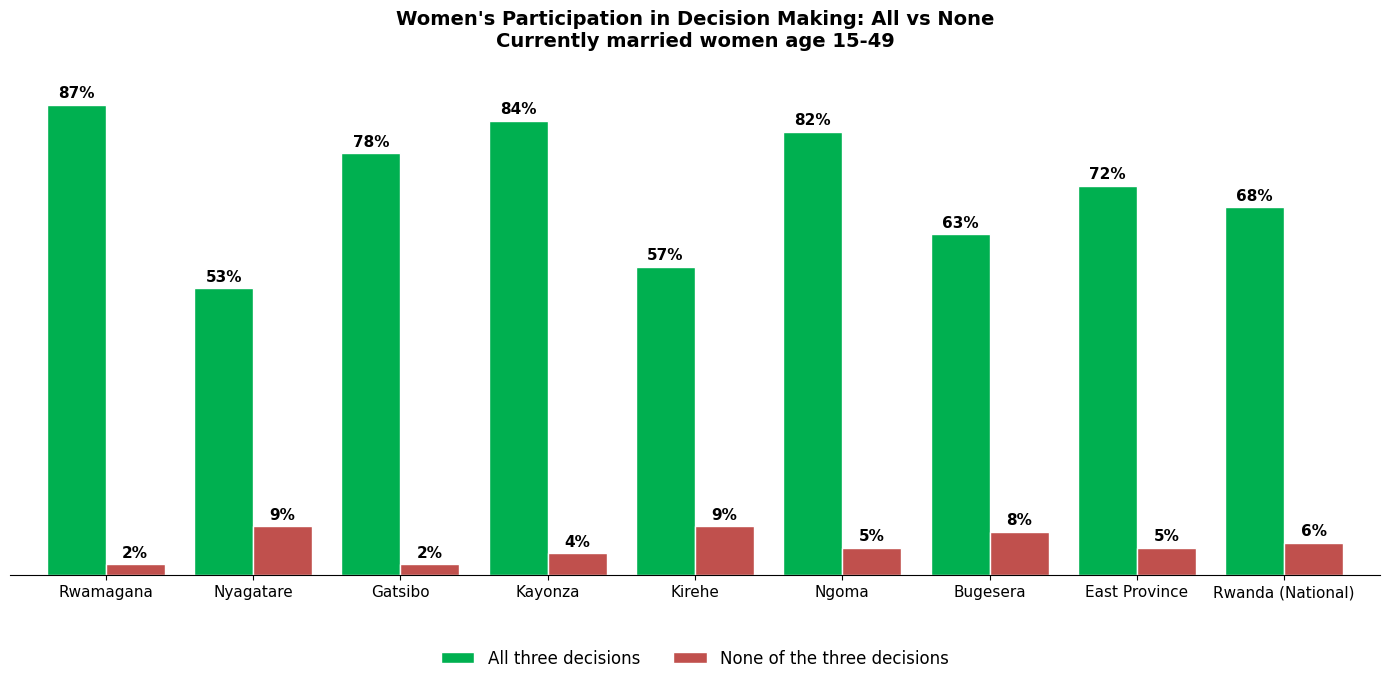

In [1]:
#!/usr/bin/env python3
# dhs_women_participation_all_or_none.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json 
import math    

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# The two indicators requested
PLOT_ORDER = ["All three decisions", "None of the three decisions"]
# Colors: All (Green), None (Red)
COLORS = ["#00B050", "#C0504D"]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """0.5 and up rounds up."""
    return int(math.floor(n + 0.5))

def get_participation_stats(df):
    """Calculates weighted % for All three vs None of the three."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return pd.Series({k: 0 for k in PLOT_ORDER})
    
    # 1. 'All three' = participates in all 3 specific domains
    is_all = (df['v743a_flag'] == 1) & (df['v743b_flag'] == 1) & (df['v743d_flag'] == 1)
    all_pct = np.average(is_all, weights=df['w']) * 100
    
    # 2. 'None' = participates in 0 domains
    is_none = (df['v743a_flag'] == 0) & (df['v743b_flag'] == 0) & (df['v743d_flag'] == 0)
    none_pct = np.average(is_none, weights=df['w']) * 100
    
    return pd.Series({
        "All three decisions": standard_round(all_pct),
        "None of the three decisions": standard_round(none_pct)
    })

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Participation: All vs None)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- ACCURACY FILTERS ---
    # 1. Currently Married (v502 == 1)
    df = df[df['v502'] == 1].copy()

    # Weights
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    dist_col = next((c for c in ['sdistrict', 'sdstr'] if c in df.columns), 'v001')

    # Convert decision variables to participation flags
    # Codes 1 (Self) and 2 (Jointly) count as participation
    for col in ['v743a', 'v743b', 'v743d']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(9)
        df[f'{col}_flag'] = df[col].isin([1, 2]).astype(int)

    # --- AGGREGATION ---
    results = {}
    df_east = df[df['v024'] == 5].copy()

    for code, name in DIST_MAP.items():
        subset = df_east[pd.to_numeric(df_east[dist_col], errors='coerce') == code]
        results[name] = get_participation_stats(subset)

    # Totals
    results["East Province"] = get_participation_stats(df_east)
    results["Rwanda (National)"] = get_participation_stats(df)

    final_df = pd.DataFrame(results).T[PLOT_ORDER]
    print("\n--- Summary Results: Participation Extreme Ends (%) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    with open("eastern_women_participation_all_none.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING (Grouped Bar Chart) ---
    ax = final_df.plot(kind="bar", figsize=(14, 7), color=COLORS, width=0.8, edgecolor="white")

    plt.title("Women's Participation in Decision Making: All vs None\nCurrently married women age 15-49", 
              fontsize=14, fontweight='bold', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    plt.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=12)

    # Add numeric labels (integers)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.savefig("Women_Participation_All_None.png", dpi=300)
    print(f"✅ Success! Results saved to eastern_women_participation_all_none.json")